In [1]:
%run init_notebook.py

from src.utils import load_pd_df, save_pd_df
from matplotlib.pyplot import cm

from src.nlp_utils import run_parallel
from src.utils import save_fig
from src.pymc_modelling import get_samp

In [3]:
tdet = load_pd_df("det_topics.feather")
tlda = load_pd_df("lda_topics2.feather").reset_index()

In [4]:
res = run_parallel(tlda.drop(['id'], axis=1), id_col='date')

This process ran 764.7


In [8]:
dict_compare_az, dict_best_nknot, dict_compare_traces, dict_data_grouped = {}, {}, {}, {}

for r in res:
    comp_az, best_k, comp_trace, data_g = r
    dict_compare_az.update(comp_az)
    dict_best_nknot.update(best_k)
    dict_compare_traces.update(comp_trace)
    dict_data_grouped.update(data_g)

# plot

In [9]:
tdet_g = tdet.drop('id', axis=1).groupby('date').sum() #/ tdet.drop('id', axis=1).groupby('date').count().iloc[:,0].values[:,None]
tdet_g = tdet_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

tlda_g = tlda.drop('id', axis=1).groupby('date').sum() #/ tlda.groupby('date').count().iloc[:,0].values[:,None]
tlda_g = tlda_g.rolling(15).mean().apply(lambda x: (x - x.min()) / (x.max() - x.min()))

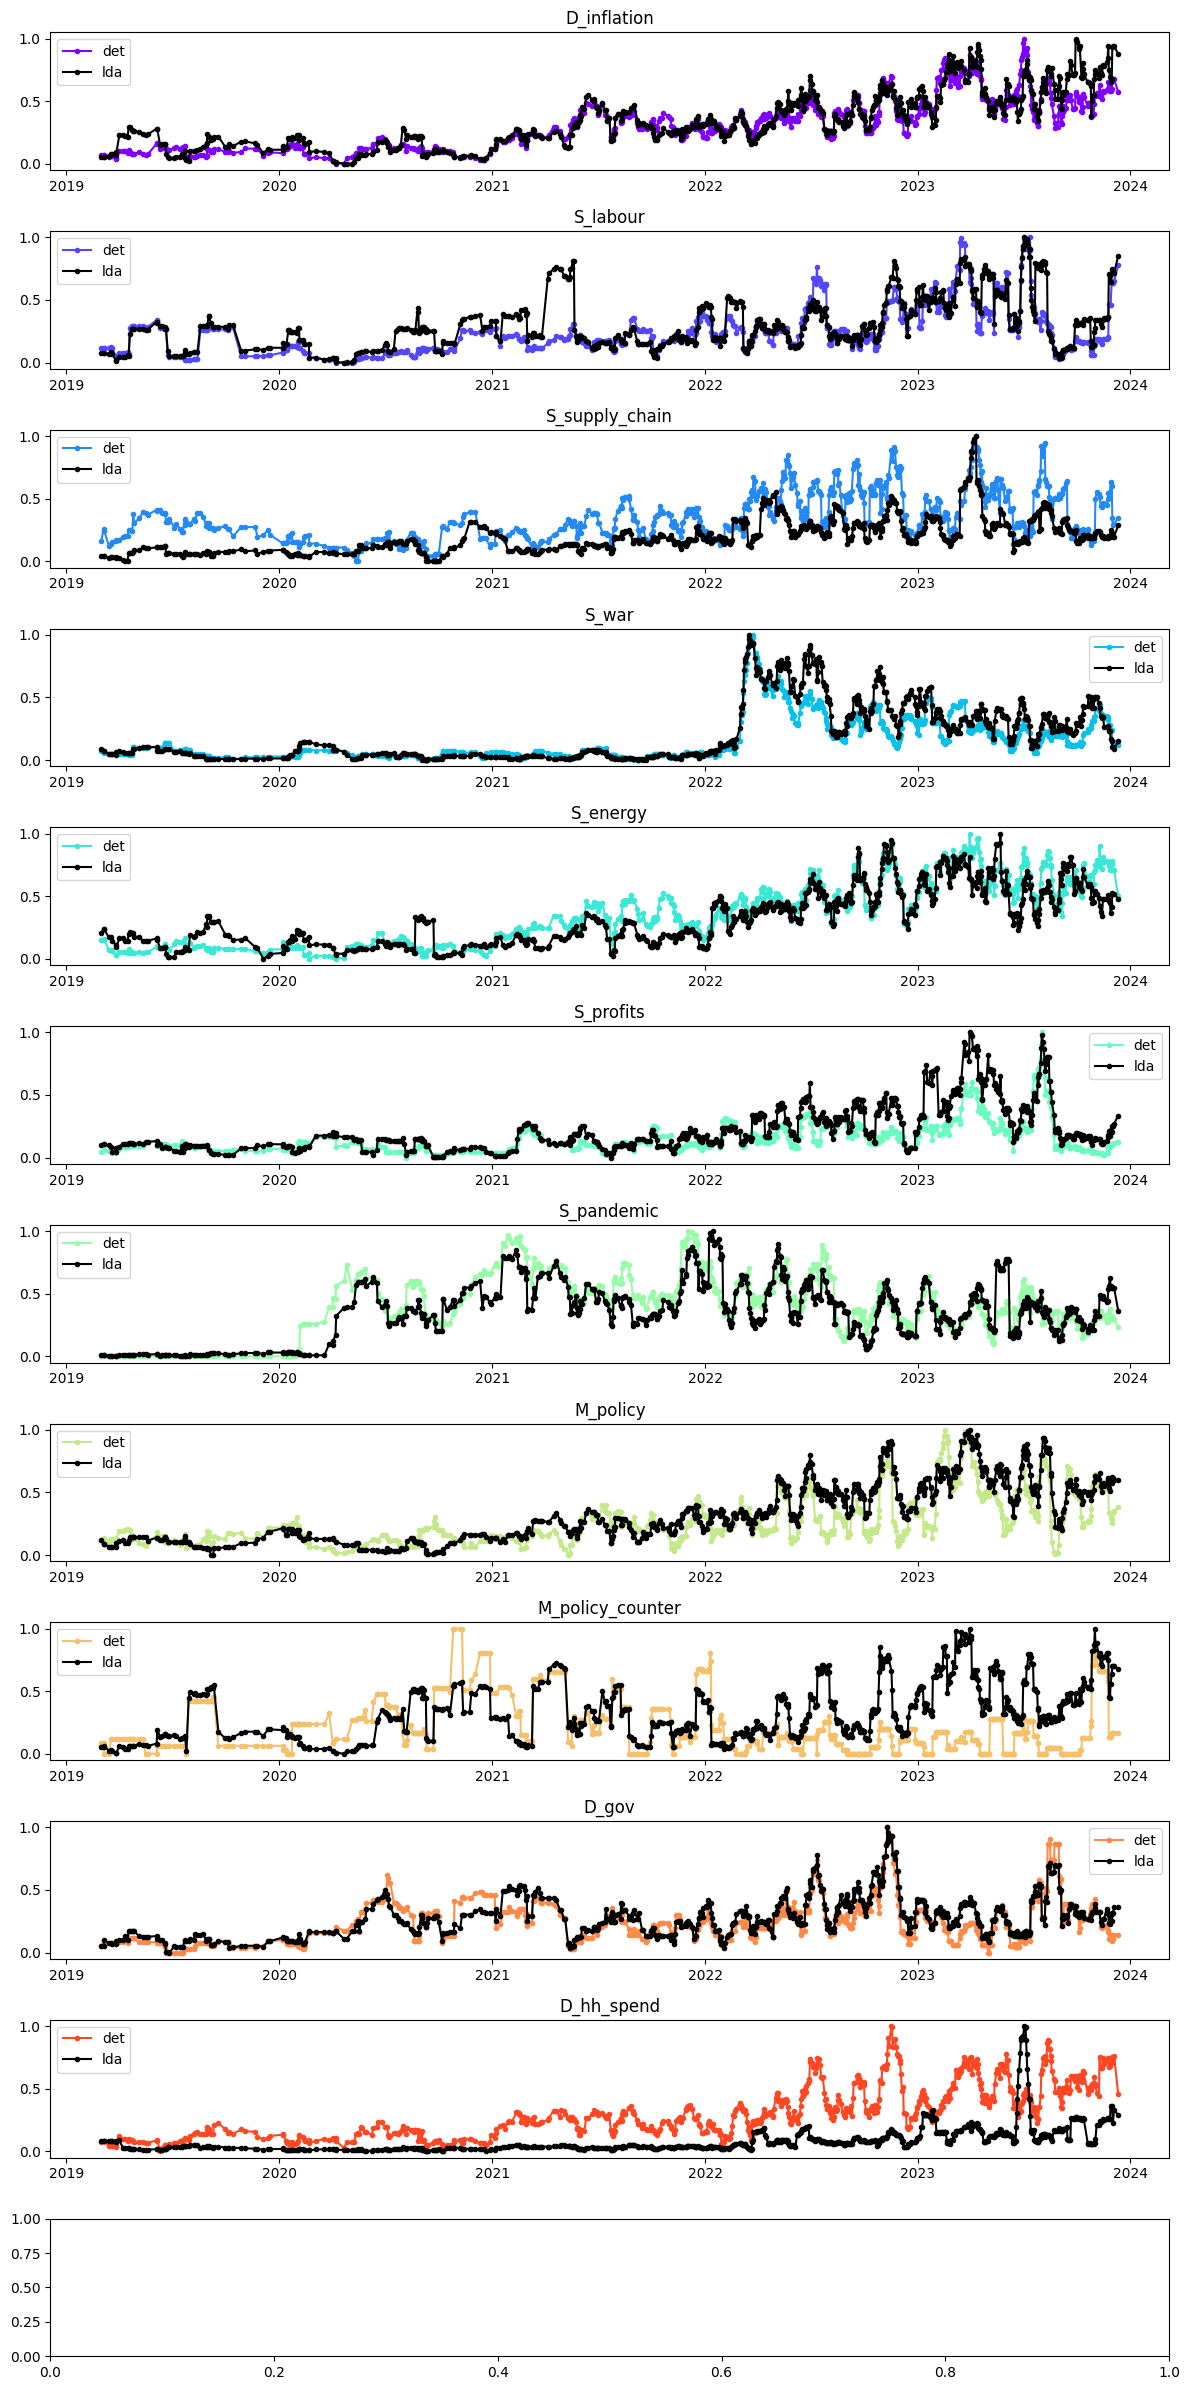

In [13]:
nrows = tlda_g.shape[1]
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

for i, ax in enumerate(axes.ravel()):
    col = tlda_g.columns[i]
    try:
        ax.plot(tdet_g.loc[:, col], c=color[i], marker='.', )
        ax.plot(tlda_g.loc[:, col], c='black', marker='.',)
    except Exception as e:
        continue
    ax.set_title(label=col)
    ax.legend(['det', 'lda'])
            
plt.tight_layout()
save_fig(fig, "02_topics_raw_det_lda.png")

# smooth

In [38]:
_ = {'D_inflation': 25,
 'S_labour': 20,
 'S_supply_chain': 20,
 # 'S_production': 20,
 'S_war': 40,
 'S_energy': 30,
 'S_profits': 20,
 'S_pandemic': 20,
 'M_policy': 20,
 'M_policy_counter': 20,
 # 'M_crisis': 20,
 'D_gov': 20,
 'D_hh_spend': 35
    }

In [39]:
dict_best_nknot.update(_)

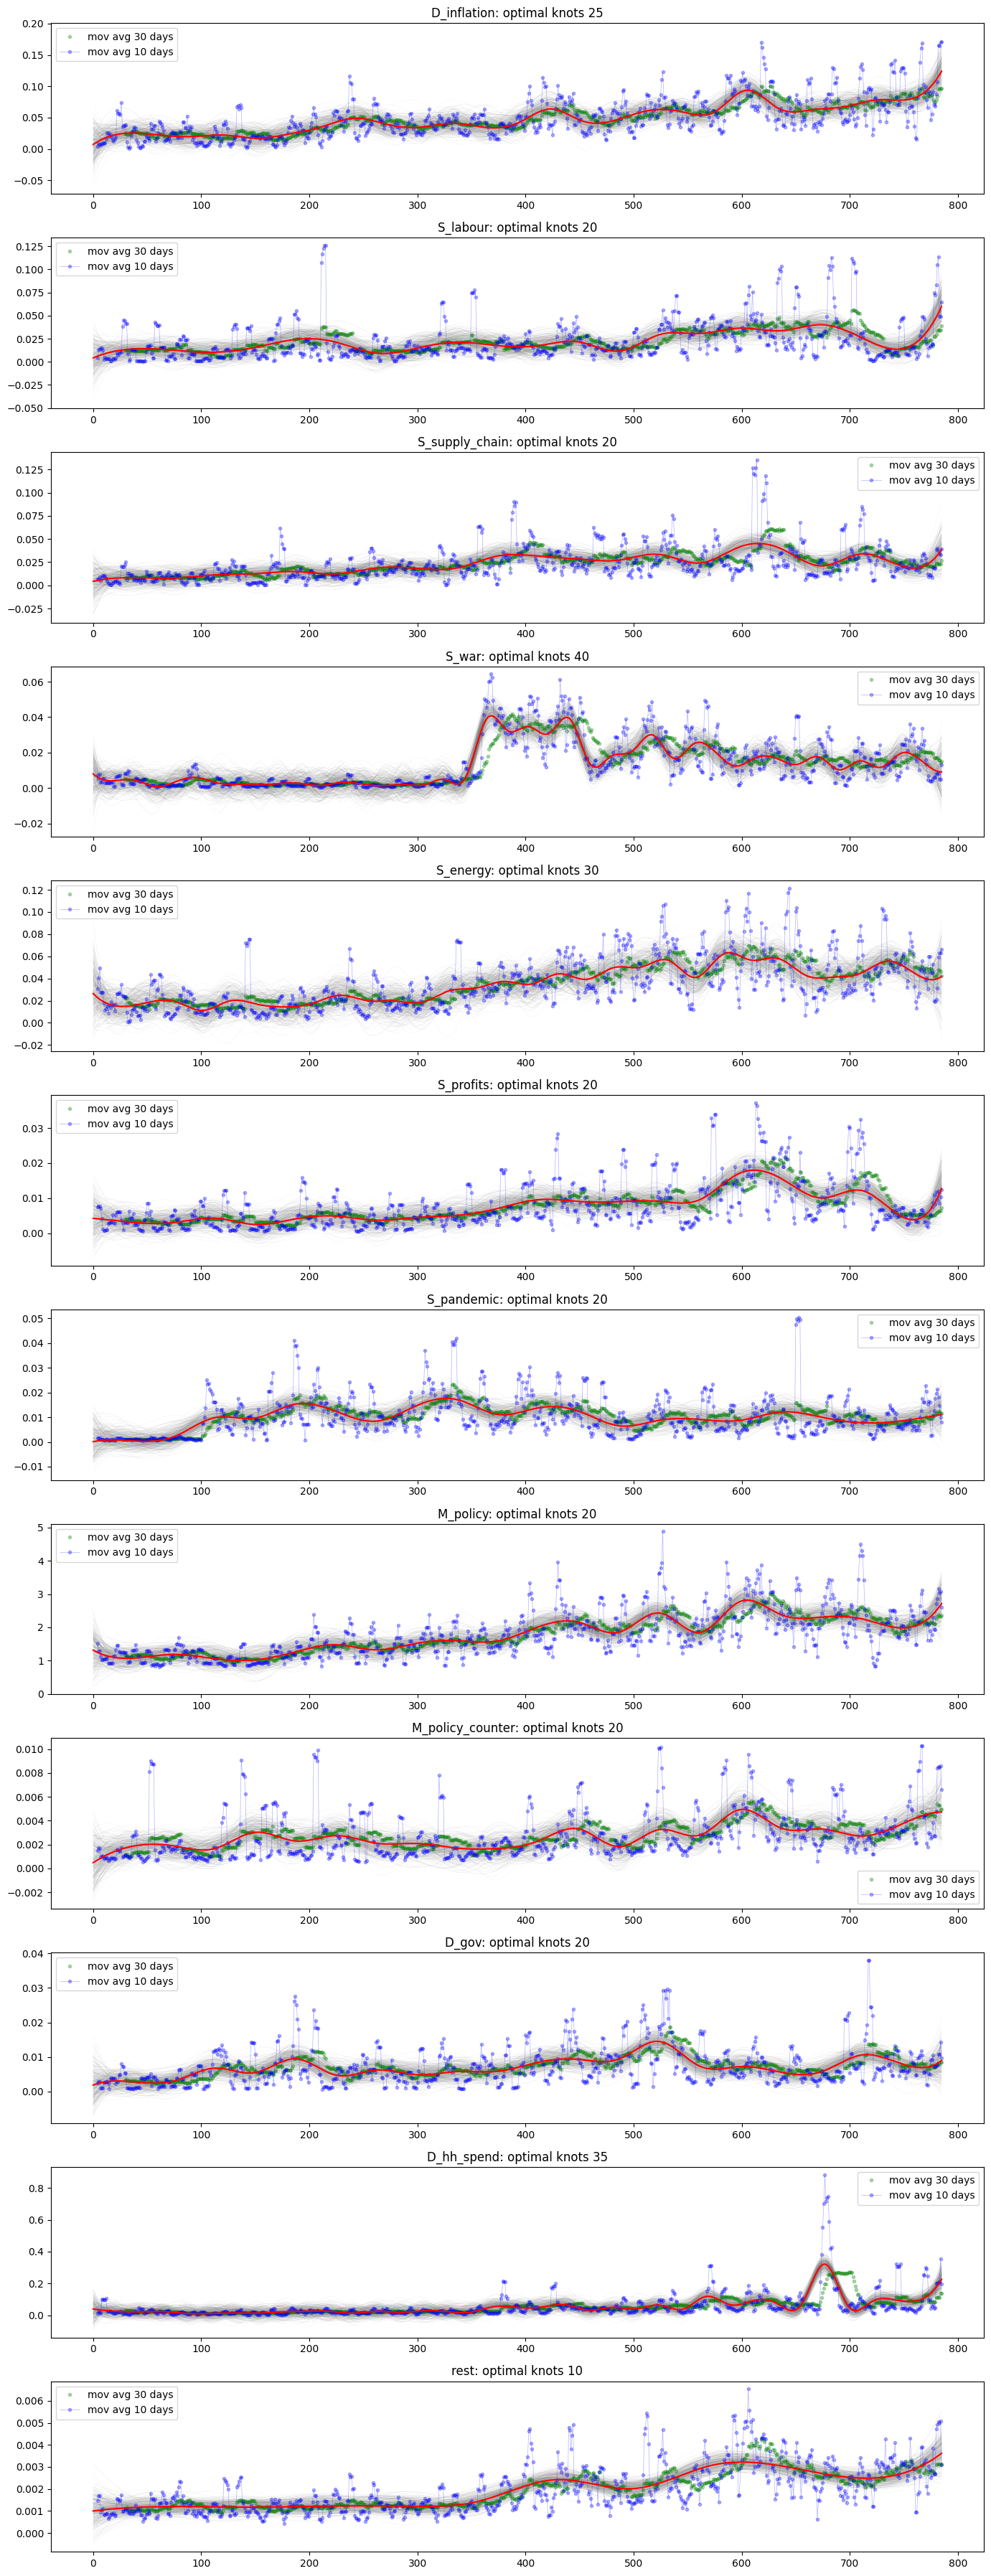

In [40]:
dict_smoothed = {}
dict_plot = {col: [dict_data_grouped[col], dict_compare_traces[col][v]] for col, v in dict_best_nknot.items()}

fig, axes = plt.subplots(len(dict_plot), 1, figsize=(14,3*len(dict_plot)))
for i, _ in enumerate(dict_plot.items()):
    col, _ = _
    data, trace = _
    
    axes.ravel()[i].set_title(f"{col}: optimal knots {dict_best_nknot[col]}") #f"knots_{trace.posterior['beta'].shape[-1]-2}", size=8)
    axes.ravel()[i].plot(
        trace.posterior['mu'][:, get_samp(1_000, 200)].values.reshape(2*200, data.shape[0]).T,
        lw=.1,
        alpha=.3,
        color='grey',
    )
    axes.ravel()[i].plot(data.rolling(30).mean().values, lw=0, marker='.', color='green', alpha=.3, label='mov avg 30 days')
    axes.ravel()[i].plot(data.rolling(5).mean().values, lw=.5, marker='.', color='blue', alpha=.3, label='mov avg 10 days')
    axes.ravel()[i].plot(trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1), color='red')
    axes.ravel()[i].legend()
    
    dict_smoothed[col] = trace.posterior['mu'][:, get_samp(1_000)].values.reshape(2*100, data.shape[0]).T.mean(axis=1)
plt.tight_layout();
save_fig(fig, "02_topics_smooth_det_lda.png")

In [41]:
tlda['date'] = tlda['date'].apply(lambda x: datetime(x.year, x.month, x.day))
tlda = tlda.set_index('date').join(pd.DataFrame(dict_smoothed, index=tlda.date.drop_duplicates()).add_suffix('_W'), how='left')

KeyError: 'date'

In [ ]:
for col in [i for i in tlda.columns if i.split('_')[-1] == 'W']:
    tlda = tlda.join(tlda[col].drop_duplicates().diff().rename(f'{col}_diff'))

# LDA

In [20]:
# topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
# topics.set_index('date', inplace=True)

topics_raw = tlda[[i for i in tlda.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)
topics_smooth = tlda[[i for i in tlda.columns if "_W" in i and "_diff" not in i]]

topics_smooth.columns = [i.split("_W")[0] for i in topics_smooth.columns]
topics_smooth = topics_smooth.join(topics_smooth.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics_smooth['T_sum_diff_lag'] = topics_smooth.T_sum.drop_duplicates().diff().shift(1)
topics_smooth = topics_smooth.drop_duplicates()

## overview on news and narratives

In [24]:
from src.processing import plt_stacked_bar

In [25]:
sub = topics_smooth.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

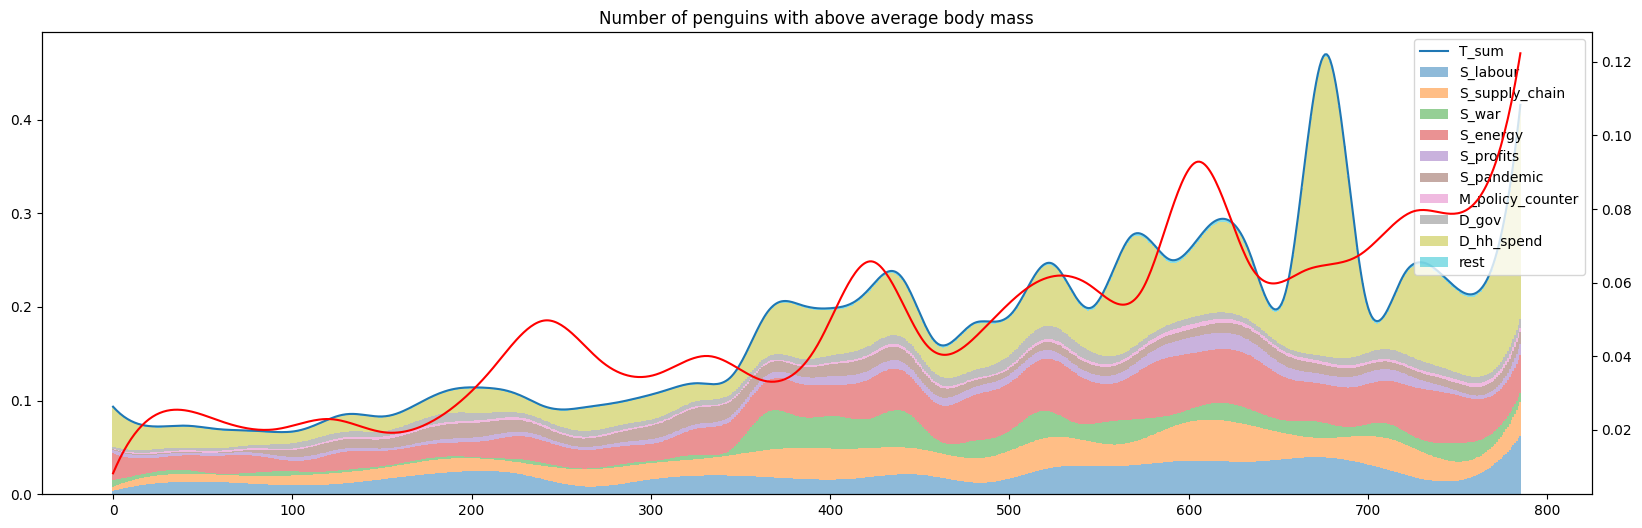

In [26]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1))
ax.plot(sub.T_sum.values, label='T_sum')
ax.twinx().plot(sub.D_inflation.values, color='red', label='D_inflation')
ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right");

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


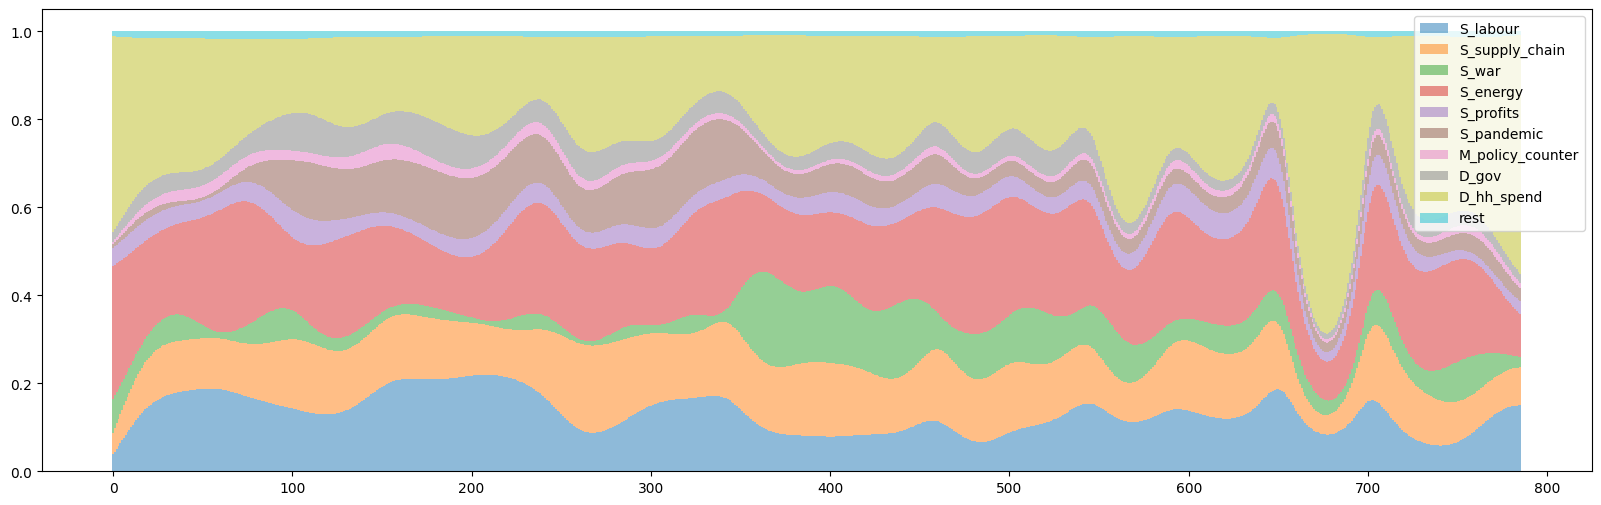

In [27]:
fig, ax = plt_stacked_bar(
    sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
)
ax.legend();

## PCA

In [32]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [33]:
X = topics_raw.drop(['D_inflation'], axis=1).diff().copy().dropna()
# X = topics_smooth.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).diff().copy().dropna()

scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), X.index, X.columns)
pca = PCA(n_components=5).fit(X_std)

In [34]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

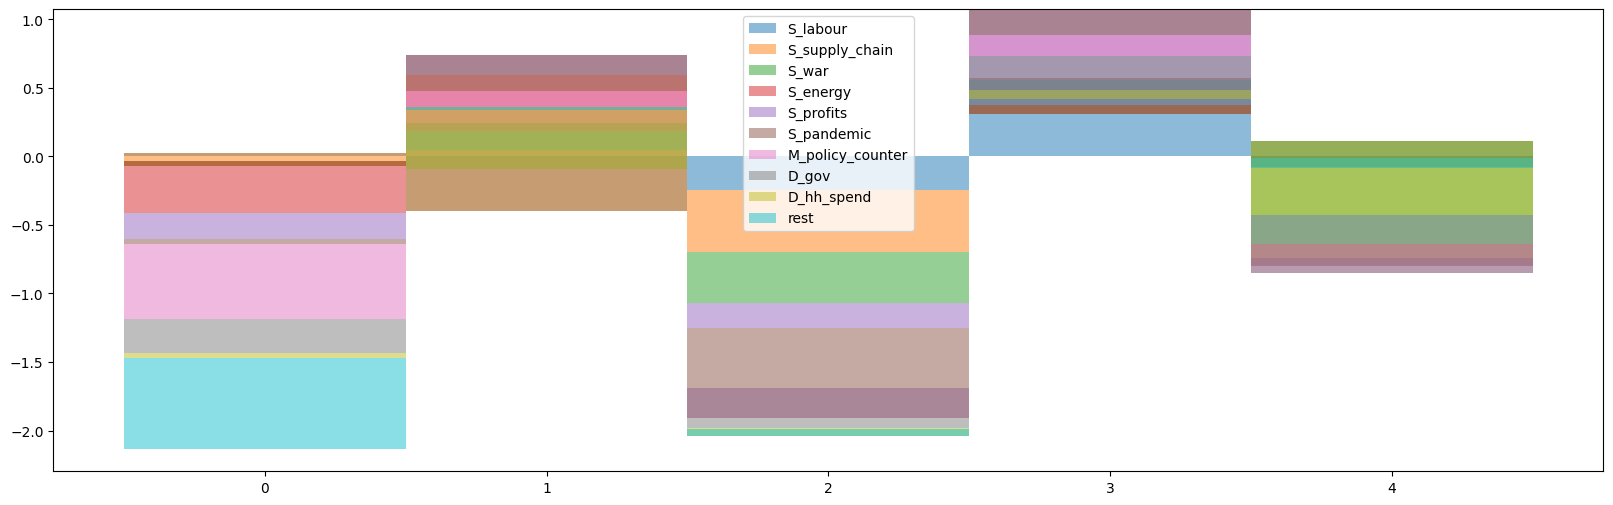

In [35]:
fig, ax = plt_stacked_bar(pd.DataFrame(pca.components_, columns = X.columns))
ax.legend(X.columns)

In [48]:
topics_raw['T_sum'] = topics_raw.drop(['D_inflation', 'rest'], axis=1).sum(axis=1)

<AxesSubplot: xlabel='date'>

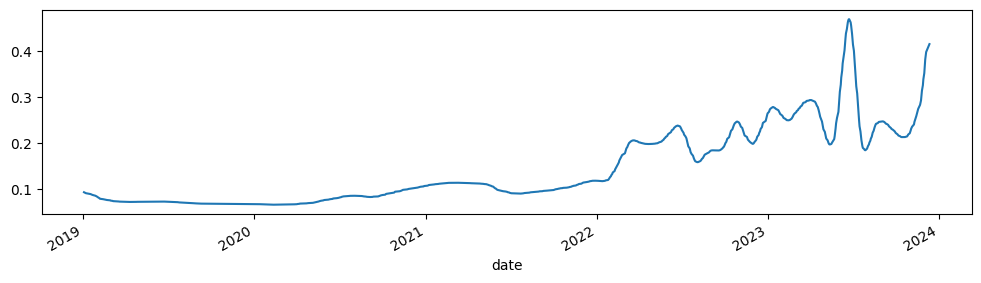

In [57]:
topics_smooth.T_sum.plot()

In [ ]:
y = topics_raw.T_sum.values
out = get_gp_smoothing(y)

Sampling: [ell, eta, f_rotated_, nu, sigma, y]
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.770952
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

<AxesSubplot: xlabel='date'>

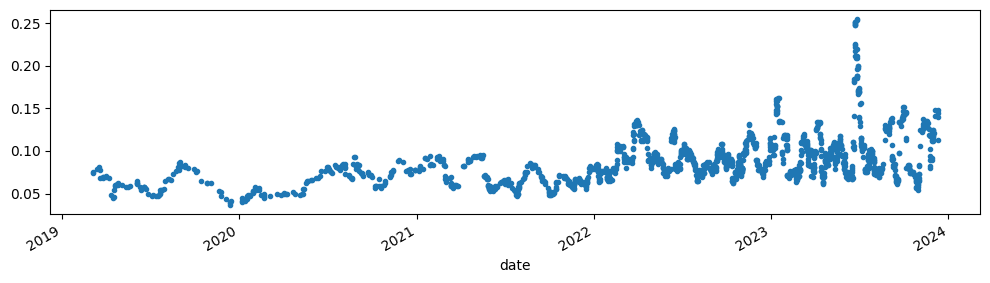

In [55]:
topics_raw.T_sum.rolling(20).mean().plot(lw=0, marker='.')

Text(0.5, 1.0, 'Components across time')

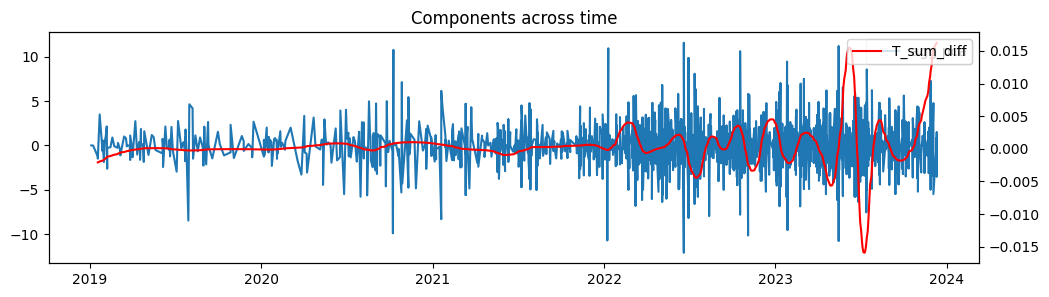

In [37]:
fig, ax = plt.subplots()

ax.plot(X.index, (pca.components_ @ X_std.T).T.sum(axis=1), label='agg pca');
ax2 = ax.twinx()
ax2.plot(topics_smooth.T_sum_diff_lag.dropna(), color='red', label='T_sum_diff')
ax.legend()
ax2.legend(loc='upper right')
plt.title('Components across time')

In [ ]:
from src.processing import ge

In [114]:
topics = topics.join(pd.Series((pca.components_ @ X_std.T).T.sum(axis=1), index=X.index, name='T_pca_sum_diff'))
topics['T_pca_sum'] = topics.T_pca_sum_diff.cumsum()

In [115]:
df = pd_join_freq(
    df.set_index('date_recorded'), 
    topics[['T_pca_sum_diff', 'T_pca_sum']].apply(lambda x: (x - x.min())/(x.max() - x.min())).copy(),
    'W', True)

df = df.reset_index(drop=True)

In [ ]:
# save data

In [57]:
tlda = tlda[[i for i in tlda.columns if 'rest' not in i]]

In [58]:
save_pd_df(tlda, 'lda_topics_smooth2.feather')